### ML Modeling

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.svm import SVR
from sklearn.base import clone
import matplotlib.font_manager as fm
import platform


In [ ]:
# 시스템에 따라 기본 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'    # macOS
else:
    plt.rcParams['font.family'] = 'NanumGothic'    # Linux (폰트 설치 필요)

# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# ✅ 모델 정의
models = {
    "RandomForest": RandomForestRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "LightGBM": LGBMRegressor(random_state=42)
}

In [4]:
# ✅ 날짜 기반 Lag 특성 생성
def create_time_series_features_date_based(df, target_col, lags=[1, 2, 3, 4, 52, 104]):
    df = df.copy()
    if 'date' not in df.columns:
        df = df.reset_index()
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index("date").sort_index()

    for lag in lags:
        df[f"lag_{lag}"] = df[target_col].shift(freq=pd.DateOffset(weeks=lag))  # ✅ 날짜 기반

    df = df.reset_index()
    df["month"] = df["date"].dt.month
    df["week"] = df["date"].dt.isocalendar().week
    df["year"] = df["date"].dt.year
    return df

# ✅ 날짜 기반 Rolling 특성 생성
def add_rolling_features_date_based(df, target_col, windows):
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')
    
    for w in windows:
        means, stds = [], []

        for current_date in df['date']:
            start_date = current_date - pd.Timedelta(weeks=w)

            mask = (df['date'] > start_date) & (df['date'] <= current_date)
            window_data = df.loc[mask, target_col]

            means.append(window_data.mean())
            stds.append(window_data.std())

        df[f'roll_mean_{w}'] = means
        df[f'roll_std_{w}'] = stds

    return df


In [5]:
# ✅ 데이터 로드
full_df = pd.read_excel('캡스톤 데이터 전처리_연령추가.xlsx')


In [6]:
full_df.head()

date    년도    주  의사환자분율  코로나  0~6세  7~18세  19~49세  50~64세  65세 이상
0 2014-09-08  2014  36주     1.7    0   0.0    0.0     0.0     0.0     0.0
1 2014-09-15  2014  37주     2.3    0   0.0    0.0     0.0     0.0     0.0
2 2014-09-22  2014  38주     2.4    0   0.0    0.0     0.0     0.0     0.0
3 2014-09-29  2014  39주     2.9    0   0.0    0.0     0.0     0.0     0.0
4 2014-10-06  2014  40주     3.1    0   0.0    0.0     0.0     0.0     0.0

In [7]:
full_df = full_df[['date','년도', '주', '의사환자분율', '코로나']]

In [8]:
full_df = full_df.sort_values(by=['date', '년도'], ascending=[True, True])
full_df = full_df.drop_duplicates(subset='date', keep='last')  # '연도 2017' 등 최신 유지

In [9]:
# 누락된 행 생성 (빈 값으로 추가)
missing_row = pd.DataFrame([{
    "date": pd.to_datetime("2024-12-30"),
    "년도": 2024,
    "주": "53주",  # 임의로 붙인 주차명
    "의사환자분율": None,
    "코로나": 0
}])

# full_df에 추가
full_df = pd.concat([full_df, missing_row], ignore_index=True)
full_df = full_df.sort_values("date").reset_index(drop=True)

# 보간 실행 (날짜 기준 정렬은 이미 되어 있어야 함)
full_df["의사환자분율"] = full_df["의사환자분율"].interpolate(method="linear")

print(full_df[full_df["date"].between("2024-12-23", "2025-01-06")])

          date    년도    주  의사환자분율  코로나
536 2024-12-23  2024  52주   73.90    0
537 2024-12-30  2024  53주   86.85    0
538 2025-01-06  2025   1주   99.80    0


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_47252\2657331855.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([full_df, missing_row], ignore_index=True)


In [10]:
rolling_windows = [3, 4, 6, 12]

lag_sets = [
    [1, 2, 3, 4],
    [1, 2, 3, 4, 52],
    [1, 2, 3, 4, 52, 104]
]

In [11]:
results = []

# ✅ 최초 학습 종료일
initial_train_end = pd.to_datetime("2024-10-21")
predict_period = pd.Timedelta(weeks=2)

# ✅ 전체 데이터 전처리
df_full = full_df.copy()

for lags in lag_sets:
    for rw in rolling_windows:
        df_lagged = create_time_series_features_date_based(df_full, '의사환자분율', lags)
        df_ready = add_rolling_features_date_based(df_lagged, '의사환자분율', [rw])
        
        lag_cols = [f"lag_{l}" for l in lags]
        roll_cols = [f"roll_mean_{rw}", f"roll_std_{rw}"]
        time_cols = ["month", "week", "year"]
        FEATURES = lag_cols + roll_cols + time_cols + ['코로나']

        df_ready = df_ready.dropna(subset=FEATURES + ['의사환자분율', '코로나'])
        df_ready = df_ready.sort_values("date").reset_index(drop=True)

        # ✅ 최대 날짜 확인
        max_date = df_ready["date"].max()
        train_end = initial_train_end

        while train_end + pd.Timedelta(days=1) <= max_date:
            # Train/Test 날짜 설정
            train_df = df_ready[df_ready["date"] <= train_end]
            test_start = train_end + pd.Timedelta(days=1)
            test_end = test_start + predict_period - pd.Timedelta(days=1)

            # 범위 초과 시 종료
            if test_start > max_date:
                break

            # 해당 기간에 실제 데이터가 있는지 확인
            test_df = df_ready[(df_ready["date"] >= test_start) & (df_ready["date"] <= test_end)]
            if test_df.empty:
                train_end = test_end
                continue  # 데이터 없으면 건너뛰고 다음

            X_train = train_df[FEATURES]
            y_train = train_df["의사환자분율"]
            X_test = test_df[FEATURES]
            y_test = test_df["의사환자분율"]

            for name, model in models.items():
                cloned_model = clone(model)
                cloned_model.fit(X_train, y_train)
                preds = cloned_model.predict(X_test)

                mae = mean_absolute_error(y_test, preds)
                rmse = np.sqrt(mean_squared_error(y_test, preds))
                r2 = r2_score(y_test, preds)

                results.append({
                    "Model": name,
                    "Lags": str(lags),
                    "RollingWindow": rw,
                    "TrainEnd": train_end.strftime('%Y-%m-%d'),
                    "TestStart": test_start.strftime('%Y-%m-%d'),
                    "TestEnd": test_end.strftime('%Y-%m-%d'),
                    "MAE": round(mae, 3),
                    "RMSE": round(rmse, 3),
                    "R2": round(r2, 3)
                })

            # ✅ 예측 구간까지 학습 데이터 확장
            train_end = test_end

# ✅ 결과 정리
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=["Model", "TrainEnd"])


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 887
[LightGBM] [Info] Number of data points in the train set: 520, number of used features: 10
[LightGBM] [Info] Start training from score 11.723077
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 933
[LightGBM] [Info] Number of data points in the train set: 550, number of used features: 10
[LightGBM] [Info] Start training from score 12.445545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 888
[LightGBM] [Info] Number of data points in the train set: 520, number of used features: 10
[LightGBM] [Info] Start training from score 11.723077
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 934
[LightGBM] [Info] Number of data points in the train set: 550, number of used features: 10
[LightGBM] [Info] Start training from score 12.445545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 550, number of used features: 10
[LightGBM] [Info] Start training from score 12.445545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 550, number of used features: 10
[LightGBM] [Info] Start training from score 12.445545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 980
[LightGBM] [Info] Number of data points in the train set: 501, number of used features: 11
[LightGBM] [Info] Start training from score 12.405689
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 980
[LightGBM] [Info] Number of data points in the train set: 501, number of used features: 11
[LightGBM] [Info] Start training from score 12.405689
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 981
[LightGBM] [Info] Number of data points in the train set: 501, number of used features: 11
[LightGBM] [Info] Start training from score 12.405689
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 982
[LightGBM] [Info] Number of data points in the train set: 501, number of used features: 11
[LightGBM] [Info] Start training from score 12.405689
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 448, number of used features: 12
[LightGBM] [Info] Start training from score 12.362388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1000
[LightGBM] [Info] Number of data points in the train set: 448, number of used features: 12
[LightGBM] [Info] Start training from score 12.362388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1001
[LightGBM] [Info] Number of data points in the train set: 448, number of used features: 12
[LightGBM] [Info] Start training from score 12.362388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1001
[LightGBM] [Info] Number of data points in the train set: 448, number of used features: 12
[LightGBM] [Info] Start training from score 12.362388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [12]:
results_df["TrainEnd"].unique()

array(['2024-10-21', '2024-11-04', '2024-11-18', '2024-12-02',
       '2024-12-16', '2024-12-30', '2025-01-13', '2025-01-27',
       '2025-02-10', '2025-02-24', '2025-03-10', '2025-03-24',
       '2025-04-07', '2025-04-21', '2025-05-05', '2025-05-19'],
      dtype=object)

In [13]:
results_df

Model                   Lags  RollingWindow    TrainEnd  \
1    GradientBoosting           [1, 2, 3, 4]              3  2024-10-21   
65   GradientBoosting           [1, 2, 3, 4]              4  2024-10-21   
129  GradientBoosting           [1, 2, 3, 4]              6  2024-10-21   
193  GradientBoosting           [1, 2, 3, 4]             12  2024-10-21   
257  GradientBoosting       [1, 2, 3, 4, 52]              3  2024-10-21   
..                ...                    ...            ...         ...   
510           XGBoost       [1, 2, 3, 4, 52]             12  2025-05-19   
574           XGBoost  [1, 2, 3, 4, 52, 104]              3  2025-05-19   
638           XGBoost  [1, 2, 3, 4, 52, 104]              4  2025-05-19   
702           XGBoost  [1, 2, 3, 4, 52, 104]              6  2025-05-19   
766           XGBoost  [1, 2, 3, 4, 52, 104]             12  2025-05-19   

      TestStart     TestEnd    MAE   RMSE      R2  
1    2024-10-22  2024-11-04  0.050  0.067  -0.772  
65   2024-10-22  2024-11-04  0.087  0.088  -2.129  
129  2024-10-22  2024-11-04  0.361  0.363 -51.653  
193  2024-10-22  2024-11-04  0.260  0.298 -34.565  
257  2024-10-22  2024-11-04  0.125  0.135  -6.288  
..          ...         ...    ...    ...     ...  
510  2025-05-20  2025-06-02  1.774  1.774     NaN  
574  2025-05-20  2025-06-02  0.082  0.082     NaN  
638  2025-05-20  2025-06-02  1.203  1.203     NaN  
702  2025-05-20  2025-06-02  0.886  0.886     NaN  
766  2025-05-20  2025-06-02  1.756  1.756     NaN  

[768 rows x 9 columns]

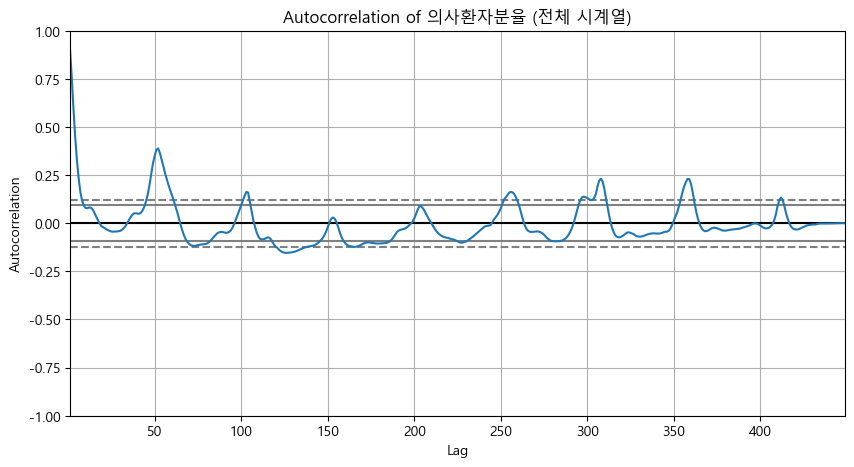

In [14]:
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot

# 자기상관 그래프를 그려볼 전체 데이터 (train + test 합쳐서 봐야 더 명확함)
combined_df = pd.concat([train_df, test_df]).sort_values("date")

# 시각화
plt.figure(figsize=(10, 5))
autocorrelation_plot(combined_df["의사환자분율"])
plt.title("Autocorrelation of 의사환자분율 (전체 시계열)")
plt.grid(True)
plt.show()

In [15]:
from statsmodels.tsa.stattools import acf, pacf
import pandas as pd

# 의사환자분율이 들어있는 시계열 데이터 (결측 제거 필수)
series = full_df["의사환자분율"].dropna()

# 최대 20주까지 lag 확인
nlags = 100

# ACF, PACF 계산
acf_values = acf(series, nlags=nlags)
pacf_values = pacf(series, nlags=nlags)

# 결과를 데이터프레임으로 보기 좋게
acf_df = pd.DataFrame({
    "Lag": list(range(len(acf_values))),
    "ACF": acf_values,
    "PACF": pacf_values
})

acf_df[50:100]

Lag       ACF      PACF
50   50  0.359739  0.105841
51   51  0.410335  0.077290
52   52  0.439785 -0.105451
53   53  0.436343 -0.073267
54   54  0.408147  0.102997
55   55  0.363304 -0.013974
56   56  0.308610 -0.031987
57   57  0.255819  0.055984
58   58  0.203101 -0.064163
59   59  0.154109  0.037274
60   60  0.108871 -0.039972
61   61  0.069073  0.010269
62   62  0.034160 -0.026651
63   63  0.006955  0.008346
64   64 -0.014403 -0.040051
65   65 -0.029026 -0.015103
66   66 -0.041779 -0.027392
67   67 -0.057210 -0.055788
68   68 -0.078155 -0.051245
69   69 -0.102558  0.002586
70   70 -0.127926 -0.017476
71   71 -0.148642 -0.019083
72   72 -0.164263 -0.038506
73   73 -0.173761  0.021071
74   74 -0.178160 -0.034841
75   75 -0.179522 -0.025590
76   76 -0.179158 -0.015807
77   77 -0.177368 -0.032171
78   78 -0.174756  0.000315
79   79 -0.171993 -0.059424
80   80 -0.168006  0.000680
81   81 -0.160721  0.026393
82   82 -0.150833 -0.021990
83   83 -0.137321  0.024900
84   84 -0.122165 -0.027396
85   85 -0.105151  0.008588
86   86 -0.084878 -0.012047
87   87 -0.064472 -0.035018
88   88 -0.043994  0.001109
89   89 -0.024302  0.021421
90   90 -0.009709 -0.049542
91   91 -0.001967 -0.039331
92   92  0.002605  0.026019
93   93  0.005565 -0.046072
94   94  0.017448  0.110070
95   95  0.039693  0.000875
96   96  0.066039 -0.040232
97   97  0.084417 -0.097951
98   98  0.095748  0.058248
99   99  0.108158  0.047137

In [16]:
# ✅ best 조합 가져오기
best_row = results_df.iloc[0]
best_lags = eval(best_row["Lags"])
best_rw = best_row["RollingWindow"]

# ✅ 동일한 feature 조합으로 데이터 재생성
df_lagged = create_time_series_features_date_based(full_df, '의사환자분율', best_lags)
df_ready = add_rolling_features_date_based(df_lagged, '의사환자분율', [best_rw])

lag_cols = [f"lag_{l}" for l in best_lags]
roll_cols = [f"roll_mean_{best_rw}", f"roll_std_{best_rw}"]
time_cols = ["month", "week", "year"]
FEATURES = lag_cols + roll_cols + time_cols + ['코로나']
# ✅ 결측치 제거 및 정렬

df_ready = df_ready.dropna(subset=FEATURES + ['의사환자분율'])
df_ready = df_ready.sort_values("date").reset_index(drop=True)

# ✅ 예측 구간 설정
initial_train_end = pd.to_datetime("2024-11-03")
predict_period = pd.Timedelta(weeks=2)
max_date = df_ready["date"].max()
train_end = initial_train_end

# ✅ 비교용 결과 저장 리스트
comparison_rows = []

while train_end + pd.Timedelta(days=1) <= max_date:
    train_df = df_ready[df_ready["date"] <= train_end]
    test_start = train_end + pd.Timedelta(days=1)
    test_end = test_start + predict_period - pd.Timedelta(days=1)

    if test_start > max_date:
        break

    test_df = df_ready[(df_ready["date"] >= test_start) & (df_ready["date"] <= test_end)]
    if test_df.empty:
        train_end = test_end
        continue

    X_train = train_df[FEATURES]
    y_train = train_df["의사환자분율"]
    X_test = test_df[FEATURES]
    y_test = test_df["의사환자분율"]

    preds_by_model = {}
    for name, model in models.items():
        cloned_model = clone(model)
        cloned_model.fit(X_train, y_train)
        preds = cloned_model.predict(X_test)
        preds_by_model[name] = preds

    # ✅ 각 날짜에 대해 예측값 저장
    for i in range(len(test_df)):
        row = {
            "date": test_df.iloc[i]["date"],
            "실제값": y_test.iloc[i]
            # 코로나도 같이 보고싶다면 "코로나": test_df.iloc[i]["코로나"]
        }
        for name in models.keys():
            row[name] = preds_by_model[name][i]
        comparison_rows.append(row)

    train_end = test_end

# ✅ DataFrame으로 변환
comparison_df = pd.DataFrame(comparison_rows).sort_values("date").reset_index(drop=True)

# ✅ 확인
print(comparison_df.head())


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 887
[LightGBM] [Info] Number of data points in the train set: 521, number of used features: 10
[LightGBM] [Info] Start training from score 11.708061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [17]:
comparison_df

date    실제값  RandomForest  GradientBoosting    XGBoost   LightGBM
0  2024-11-04   4.00         3.890          4.076488   3.842892   3.895995
1  2024-11-11   4.60         4.404          4.527490   4.413386   4.564455
2  2024-11-18   4.80         4.868          4.990954   4.910367   4.834959
3  2024-11-25   5.70         5.566          5.413061   5.566297   5.622029
4  2024-12-02   7.30         7.137          6.650740   7.437788   6.136571
5  2024-12-09  13.60        12.999         13.943247  13.275219  11.330908
6  2024-12-16  31.30        25.641         26.904950  29.944063  28.304265
7  2024-12-23  73.90        56.345         60.759954  59.960903  57.095955
8  2024-12-30  86.85        70.687         73.586254  67.084908  64.204977
9  2025-01-06  99.80        64.001         66.196781  48.402981  59.665455
10 2025-01-13  86.10        71.061         77.583200  64.904144  53.176903
11 2025-01-20  57.70        68.575         77.380424  48.606579  57.940271
12 2025-01-27  36.50        55.584         38.582944  45.012848  61.985569
13 2025-02-03  30.40        34.494         33.706300  28.192474  38.323955
14 2025-02-10  13.90        19.601         18.876992  16.549585  21.231557
15 2025-02-17  11.60        14.297         14.993625  14.001782  12.096298
16 2025-02-24   9.50         9.277          8.732641   8.639894  10.354175
17 2025-03-03   9.10         8.468          8.387938   7.469651   8.875162
18 2025-03-10   8.00         9.122          9.645946   9.690524   8.714770
19 2025-03-17  10.80         9.262         10.222657   9.811362   9.787926
20 2025-03-24  13.20        12.500         11.438445  12.851443  13.680254
21 2025-03-31  16.30        16.877         15.087316  16.794092  18.723318
22 2025-04-07  16.90        17.467         19.271029  19.350641  21.360830
23 2025-04-14  21.60        18.461         20.299782  20.071768  26.912189
24 2025-04-21  20.80        22.835         24.174019  22.356020  23.249339
25 2025-04-28  16.10        19.892         16.671803  22.361393  23.082918
26 2025-05-05  13.10        15.157         14.612439  15.618180  12.576908
27 2025-05-12  11.60        13.339         13.089375  11.966419  12.975806
28 2025-05-19  10.10         9.028         10.073352   9.216315   9.338338
29 2025-05-26   7.30         8.007          8.540746   7.488248   7.933006

In [18]:
comparison_df.to_excel('ML for ensemble.xlsx', index=False)

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 결과 저장 리스트
model_metrics = []

for model_name in comparison_df.columns[2:]:  # 모델 열들만
    y_true = comparison_df["실제값"]
    y_pred = comparison_df[model_name]

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    model_metrics.append({
        "모델": model_name,
        "MAE": round(mae, 3),
        "RMSE": round(rmse, 3),
        "R²": round(r2, 3)
    })

# 정리된 성능표
import pandas as pd
metrics_df = pd.DataFrame(model_metrics).sort_values(by="MAE")
print(metrics_df)


                 모델    MAE    RMSE     R²
1  GradientBoosting  4.218   8.252  0.905
0      RandomForest  5.128   9.471  0.874
2           XGBoost  5.178  11.425  0.817
3          LightGBM  6.296  12.092  0.795


In [20]:
dasdsad

NameError: name 'dasdsad' is not defined

## 유아 Model

In [ ]:
# ✅ 데이터 로드
full_df = pd.read_excel('캡스톤 데이터 전처리_연령추가.xlsx')


In [ ]:
full_df.head()

date    년도    주  의사환자분율  코로나  0~6세  7~18세  19~49세  50~64세  65세 이상
0 2014-09-08  2014  36주     1.7    0   0.0    0.0     0.0     0.0     0.0
1 2014-09-15  2014  37주     2.3    0   0.0    0.0     0.0     0.0     0.0
2 2014-09-22  2014  38주     2.4    0   0.0    0.0     0.0     0.0     0.0
3 2014-09-29  2014  39주     2.9    0   0.0    0.0     0.0     0.0     0.0
4 2014-10-06  2014  40주     3.1    0   0.0    0.0     0.0     0.0     0.0

In [ ]:
full_df = full_df[['date','년도', '주', '0~6세', '코로나']]

In [ ]:
full_df = full_df.sort_values(by=['date', '년도'], ascending=[True, True])
full_df = full_df.drop_duplicates(subset='date', keep='last')  # '연도 2017' 등 최신 유지

In [ ]:
full_df = full_df[full_df['date'] > pd.to_datetime("2017-07-01")]

In [ ]:
full_df

date    년도    주  0~6세  코로나
148 2017-07-03  2017  27주   9.7    0
149 2017-07-10  2017  28주  10.0    0
150 2017-07-17  2017  29주  10.3    0
151 2017-07-24  2017  30주   6.6    0
152 2017-07-31  2017  31주   6.8    0
..         ...   ...  ...   ...  ...
547 2025-03-03  2025   9주  10.2    0
548 2025-03-10  2025  10주   8.7    0
549 2025-03-17  2025  11주  10.5    0
550 2025-03-24  2025  12주  10.9    0
551 2025-03-31  2025  13주  12.1    0

[403 rows x 5 columns]

In [ ]:
# 누락된 행 생성 (빈 값으로 추가)
missing_row = pd.DataFrame([{
    "date": pd.to_datetime("2024-12-30"),
    "년도": 2024,
    "주": "53주",  # 임의로 붙인 주차명
    "0~6세": None,
    "코로나": 0
}])

# full_df에 추가
full_df = pd.concat([full_df, missing_row], ignore_index=True)
full_df = full_df.sort_values("date").reset_index(drop=True)

# 보간 실행 (날짜 기준 정렬은 이미 되어 있어야 함)
full_df["0~6세"] = full_df["0~6세"].interpolate(method="linear")

print(full_df[full_df["date"].between("2024-12-23", "2025-01-06")])

          date    년도    주  0~6세  코로나
389 2024-12-23  2024  52주  54.4    0
390 2024-12-30  2024  53주  66.7    0
391 2025-01-06  2025   1주  79.0    0


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_43800\3040210617.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([full_df, missing_row], ignore_index=True)


In [ ]:
rolling_windows = [3, 4, 6, 12]

lag_sets = [
    [1, 2, 3, 4],
    [1, 2, 3, 4, 52],
    [1, 2, 3, 4, 52, 104]
]

In [ ]:
results = []

# ✅ 최초 학습 종료일
initial_train_end = pd.to_datetime("2024-11-03")
predict_period = pd.Timedelta(weeks=2)

# ✅ 전체 데이터 전처리
df_full = full_df.copy()

for lags in lag_sets:
    for rw in rolling_windows:
        df_lagged = create_time_series_features_date_based(df_full, '0~6세', lags)
        df_ready = add_rolling_features_date_based(df_lagged, '0~6세', [rw])
        
        lag_cols = [f"lag_{l}" for l in lags]
        roll_cols = [f"roll_mean_{rw}", f"roll_std_{rw}"]
        time_cols = ["month", "week", "year"]
        FEATURES = lag_cols + roll_cols + time_cols + ['코로나']

        df_ready = df_ready.dropna(subset=FEATURES + ['0~6세', '코로나'])
        df_ready = df_ready.sort_values("date").reset_index(drop=True)

        # ✅ 최대 날짜 확인
        max_date = df_ready["date"].max()
        train_end = initial_train_end

        while train_end + pd.Timedelta(days=1) <= max_date:
            # Train/Test 날짜 설정
            train_df = df_ready[df_ready["date"] <= train_end]
            test_start = train_end + pd.Timedelta(days=1)
            test_end = test_start + predict_period - pd.Timedelta(days=1)

            # 범위 초과 시 종료
            if test_start > max_date:
                break

            # 해당 기간에 실제 데이터가 있는지 확인
            test_df = df_ready[(df_ready["date"] >= test_start) & (df_ready["date"] <= test_end)]
            if test_df.empty:
                train_end = test_end
                continue  # 데이터 없으면 건너뛰고 다음

            X_train = train_df[FEATURES]
            y_train = train_df["0~6세"]
            X_test = test_df[FEATURES]
            y_test = test_df["0~6세"]

            for name, model in models.items():
                cloned_model = clone(model)
                cloned_model.fit(X_train, y_train)
                preds = cloned_model.predict(X_test)

                mae = mean_absolute_error(y_test, preds)
                rmse = np.sqrt(mean_squared_error(y_test, preds))
                r2 = r2_score(y_test, preds)

                results.append({
                    "Model": name,
                    "Lags": str(lags),
                    "RollingWindow": rw,
                    "TrainEnd": train_end.strftime('%Y-%m-%d'),
                    "TestStart": test_start.strftime('%Y-%m-%d'),
                    "TestEnd": test_end.strftime('%Y-%m-%d'),
                    "MAE": round(mae, 3),
                    "RMSE": round(rmse, 3),
                    "R2": round(r2, 3)
                })

            # ✅ 예측 구간까지 학습 데이터 확장
            train_end = test_end

# ✅ 결과 정리
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=["Model", "TrainEnd"])


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 704
[LightGBM] [Info] Number of data points in the train set: 374, number of used features: 10
[LightGBM] [Info] Start training from score 12.545989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [ ]:
results_df["TrainEnd"].unique()

array(['2024-11-03', '2024-11-17', '2024-12-01', '2024-12-15',
       '2024-12-29', '2025-01-12', '2025-01-26', '2025-02-09',
       '2025-02-23', '2025-03-09', '2025-03-23'], dtype=object)

In [ ]:
results_df

Model                   Lags  RollingWindow    TrainEnd  \
1    GradientBoosting           [1, 2, 3, 4]              3  2024-11-03   
45   GradientBoosting           [1, 2, 3, 4]              4  2024-11-03   
89   GradientBoosting           [1, 2, 3, 4]              6  2024-11-03   
133  GradientBoosting           [1, 2, 3, 4]             12  2024-11-03   
177  GradientBoosting       [1, 2, 3, 4, 52]              3  2024-11-03   
..                ...                    ...            ...         ...   
350           XGBoost       [1, 2, 3, 4, 52]             12  2025-03-23   
394           XGBoost  [1, 2, 3, 4, 52, 104]              3  2025-03-23   
438           XGBoost  [1, 2, 3, 4, 52, 104]              4  2025-03-23   
482           XGBoost  [1, 2, 3, 4, 52, 104]              6  2025-03-23   
526           XGBoost  [1, 2, 3, 4, 52, 104]             12  2025-03-23   

      TestStart     TestEnd    MAE   RMSE      R2  
1    2024-11-04  2024-11-17  0.400  0.479  -0.434  
45   2024-11-04  2024-11-17  0.604  0.710  -2.147  
89   2024-11-04  2024-11-17  1.281  1.282  -9.265  
133  2024-11-04  2024-11-17  1.360  1.361 -10.572  
177  2024-11-04  2024-11-17  0.400  0.415  -0.076  
..          ...         ...    ...    ...     ...  
350  2025-03-24  2025-04-06  0.899  1.053  -2.082  
394  2025-03-24  2025-04-06  1.075  1.094  -2.327  
438  2025-03-24  2025-04-06  2.018  2.020 -10.331  
482  2025-03-24  2025-04-06  0.868  0.875  -1.124  
526  2025-03-24  2025-04-06  1.511  1.523  -5.443  

[528 rows x 9 columns]

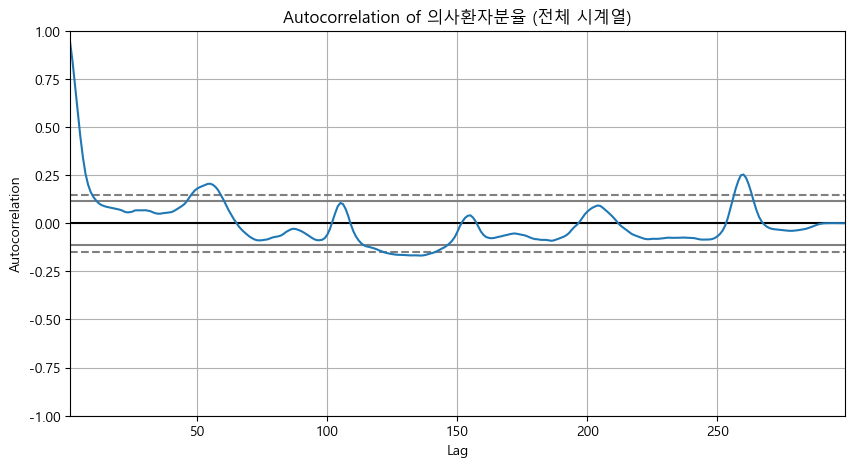

In [ ]:
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot

# 자기상관 그래프를 그려볼 전체 데이터 (train + test 합쳐서 봐야 더 명확함)
combined_df = pd.concat([train_df, test_df]).sort_values("date")

# 시각화
plt.figure(figsize=(10, 5))
autocorrelation_plot(combined_df["0~6세"])
plt.title("Autocorrelation of 의사환자분율 (전체 시계열)")
plt.grid(True)
plt.show()

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
import pandas as pd

# 의사환자분율이 들어있는 시계열 데이터 (결측 제거 필수)
series = full_df["0~6세"].dropna()

# 최대 20주까지 lag 확인
nlags = 100

# ACF, PACF 계산
acf_values = acf(series, nlags=nlags)
pacf_values = pacf(series, nlags=nlags)

# 결과를 데이터프레임으로 보기 좋게
acf_df = pd.DataFrame({
    "Lag": list(range(len(acf_values))),
    "ACF": acf_values,
    "PACF": pacf_values
})

acf_df[50:100]

Lag       ACF      PACF
50   50  0.308151  0.008085
51   51  0.325490 -0.106130
52   52  0.326957  0.048294
53   53  0.287215 -0.159412
54   54  0.258761  0.079808
55   55  0.223365  0.011946
56   56  0.184748 -0.029862
57   57  0.135292 -0.018124
58   58  0.104361  0.097698
59   59  0.083243  0.010921
60   60  0.073487  0.005745
61   61  0.061690 -0.020628
62   62  0.046053 -0.037088
63   63  0.039392 -0.001382
64   64  0.031985 -0.008879
65   65  0.022662 -0.027389
66   66  0.003023  0.016827
67   67 -0.014832 -0.019033
68   68 -0.030984 -0.045473
69   69 -0.060173 -0.036168
70   70 -0.078025 -0.036342
71   71 -0.092819  0.093409
72   72 -0.106183 -0.105942
73   73 -0.116298 -0.002769
74   74 -0.120765 -0.012340
75   75 -0.122023  0.017188
76   76 -0.121968 -0.045237
77   77 -0.122024 -0.002110
78   78 -0.116945 -0.013749
79   79 -0.113051 -0.038184
80   80 -0.108833  0.028820
81   81 -0.106232 -0.043817
82   82 -0.105446 -0.045538
83   83 -0.102194  0.046207
84   84 -0.095823 -0.018660
85   85 -0.091504 -0.053541
86   86 -0.086058 -0.046204
87   87 -0.084675  0.002102
88   88 -0.083025 -0.000116
89   89 -0.082728 -0.069534
90   90 -0.081542  0.024674
91   91 -0.080238 -0.051518
92   92 -0.077743  0.027566
93   93 -0.069070  0.020544
94   94 -0.056802 -0.003964
95   95 -0.041528 -0.013409
96   96 -0.020845  0.047214
97   97  0.005265  0.037316
98   98  0.032255 -0.028196
99   99  0.066018  0.023385

In [ ]:
# ✅ best 조합 가져오기
best_row = results_df.iloc[0]
best_lags = eval(best_row["Lags"])
best_rw = best_row["RollingWindow"]

# ✅ 동일한 feature 조합으로 데이터 재생성
df_lagged = create_time_series_features_date_based(full_df, '0~6세', best_lags)
df_ready = add_rolling_features_date_based(df_lagged, '0~6세', [best_rw])

lag_cols = [f"lag_{l}" for l in best_lags]
roll_cols = [f"roll_mean_{best_rw}", f"roll_std_{best_rw}"]
time_cols = ["month", "week", "year"]
FEATURES = lag_cols + roll_cols + time_cols + ['코로나']
# ✅ 결측치 제거 및 정렬

df_ready = df_ready.dropna(subset=FEATURES + ['0~6세'])
df_ready = df_ready.sort_values("date").reset_index(drop=True)

# ✅ 예측 구간 설정
initial_train_end = pd.to_datetime("2024-11-03")
predict_period = pd.Timedelta(weeks=2)
max_date = df_ready["date"].max()
train_end = initial_train_end

# ✅ 비교용 결과 저장 리스트
comparison_rows = []

while train_end + pd.Timedelta(days=1) <= max_date:
    train_df = df_ready[df_ready["date"] <= train_end]
    test_start = train_end + pd.Timedelta(days=1)
    test_end = test_start + predict_period - pd.Timedelta(days=1)

    if test_start > max_date:
        break

    test_df = df_ready[(df_ready["date"] >= test_start) & (df_ready["date"] <= test_end)]
    if test_df.empty:
        train_end = test_end
        continue

    X_train = train_df[FEATURES]
    y_train = train_df["0~6세"]
    X_test = test_df[FEATURES]
    y_test = test_df["0~6세"]

    preds_by_model = {}
    for name, model in models.items():
        cloned_model = clone(model)
        cloned_model.fit(X_train, y_train)
        preds = cloned_model.predict(X_test)
        preds_by_model[name] = preds

    # ✅ 각 날짜에 대해 예측값 저장
    for i in range(len(test_df)):
        row = {
            "date": test_df.iloc[i]["date"],
            "실제값": y_test.iloc[i]
            # 코로나도 같이 보고싶다면 "코로나": test_df.iloc[i]["코로나"]
        }
        for name in models.keys():
            row[name] = preds_by_model[name][i]
        comparison_rows.append(row)

    train_end = test_end

# ✅ DataFrame으로 변환
comparison_df = pd.DataFrame(comparison_rows).sort_values("date").reset_index(drop=True)

# ✅ 확인
print(comparison_df.head())

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 704
[LightGBM] [Info] Number of data points in the train set: 374, number of used features: 10
[LightGBM] [Info] Start training from score 12.545989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [ ]:
comparison_df

date   실제값  RandomForest  GradientBoosting    XGBoost   LightGBM
0  2024-11-04   3.6         3.802          4.263449   3.811589   3.999678
1  2024-11-11   4.4         3.910          4.263449   3.983542   3.904376
2  2024-11-18   4.9         4.303          4.555565   3.784008   4.017186
3  2024-11-25   5.1         4.830          5.085614   4.662909   4.183447
4  2024-12-02   5.5         5.335          5.257367   5.165638   5.609259
5  2024-12-09   9.7         6.191          7.150375   6.553946   7.841528
6  2024-12-16  23.1        13.880         12.896638  13.240786  14.781556
7  2024-12-23  54.4        41.940         48.121742  41.145443  41.850196
8  2024-12-30  66.7        58.716         65.984065  53.661011  62.667992
9  2025-01-06  79.0        59.231         56.457148  52.733688  57.893859
10 2025-01-13  79.6        74.077         83.169452  61.051342  62.829298
11 2025-01-20  71.5        72.509         83.262942  68.307098  57.850953
12 2025-01-27  48.6        61.741         58.579144  61.029224  54.082102
13 2025-02-03  34.9        45.049         41.662637  33.805622  54.082102
14 2025-02-10  18.4        30.895         27.046608  12.159733  11.645641
15 2025-02-17  16.6        18.762         17.961494  16.237368  15.721847
16 2025-02-24  11.1        12.320          9.833691  10.933323  12.064640
17 2025-03-03  10.2        11.609         11.172357  11.370180   9.272668
18 2025-03-10   8.7         9.329          8.790987   8.429440   9.337334
19 2025-03-17  10.5         9.510          8.990349   9.161572   8.562937
20 2025-03-24  10.9         9.467          9.686306  10.190978  10.523958
21 2025-03-31  12.1        11.404         11.632541  11.116747  12.042122

In [ ]:
comparison_df.to_excel('ML for ensemble_young.xlsx', index=False)

### old 예측

In [ ]:
# ✅ 데이터 로드
full_df = pd.read_excel('캡스톤 데이터 전처리_연령추가.xlsx')


In [ ]:
full_df.head()

date    년도    주  의사환자분율  코로나  0~6세  7~18세  19~49세  50~64세  65세 이상
0 2014-09-08  2014  36주     1.7    0   0.0    0.0     0.0     0.0     0.0
1 2014-09-15  2014  37주     2.3    0   0.0    0.0     0.0     0.0     0.0
2 2014-09-22  2014  38주     2.4    0   0.0    0.0     0.0     0.0     0.0
3 2014-09-29  2014  39주     2.9    0   0.0    0.0     0.0     0.0     0.0
4 2014-10-06  2014  40주     3.1    0   0.0    0.0     0.0     0.0     0.0

In [ ]:
full_df = full_df[['date','년도', '주', '65세 이상', '코로나']]

In [ ]:
full_df = full_df.sort_values(by=['date', '년도'], ascending=[True, True])
full_df = full_df.drop_duplicates(subset='date', keep='last')  # '연도 2017' 등 최신 유지

In [ ]:
# 누락된 행 생성 (빈 값으로 추가)
missing_row = pd.DataFrame([{
    "date": pd.to_datetime("2024-12-30"),
    "년도": 2024,
    "주": "53주",  # 임의로 붙인 주차명
    "65세 이상": None,
    "코로나": 0
}])

# full_df에 추가
full_df = pd.concat([full_df, missing_row], ignore_index=True)
full_df = full_df.sort_values("date").reset_index(drop=True)

# 보간 실행 (날짜 기준 정렬은 이미 되어 있어야 함)
full_df["65세 이상"] = full_df["65세 이상"].interpolate(method="linear")

print(full_df[full_df["date"].between("2024-12-23", "2025-01-06")])

          date    년도    주  65세 이상  코로나
536 2024-12-23  2024  52주    20.3    0
537 2024-12-30  2024  53주    27.7    0
538 2025-01-06  2025   1주    35.1    0


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_43800\870323696.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([full_df, missing_row], ignore_index=True)


In [ ]:
rolling_windows = [3, 4, 6, 12]

lag_sets = [
    [1, 2, 3, 4],
    [1, 2, 3, 4, 52],
    [1, 2, 3, 4, 52, 104]
]

In [ ]:
results = []

# ✅ 최초 학습 종료일
initial_train_end = pd.to_datetime("2024-11-03")
predict_period = pd.Timedelta(weeks=2)

# ✅ 전체 데이터 전처리
df_full = full_df.copy()

for lags in lag_sets:
    for rw in rolling_windows:
        df_lagged = create_time_series_features_date_based(df_full, '65세 이상', lags)
        df_ready = add_rolling_features_date_based(df_lagged, '65세 이상', [rw])
        
        lag_cols = [f"lag_{l}" for l in lags]
        roll_cols = [f"roll_mean_{rw}", f"roll_std_{rw}"]
        time_cols = ["month", "week", "year"]
        FEATURES = lag_cols + roll_cols + time_cols + ['코로나']

        df_ready = df_ready.dropna(subset=FEATURES + ['65세 이상', '코로나'])
        df_ready = df_ready.sort_values("date").reset_index(drop=True)

        # ✅ 최대 날짜 확인
        max_date = df_ready["date"].max()
        train_end = initial_train_end

        while train_end + pd.Timedelta(days=1) <= max_date:
            # Train/Test 날짜 설정
            train_df = df_ready[df_ready["date"] <= train_end]
            test_start = train_end + pd.Timedelta(days=1)
            test_end = test_start + predict_period - pd.Timedelta(days=1)

            # 범위 초과 시 종료
            if test_start > max_date:
                break

            # 해당 기간에 실제 데이터가 있는지 확인
            test_df = df_ready[(df_ready["date"] >= test_start) & (df_ready["date"] <= test_end)]
            if test_df.empty:
                train_end = test_end
                continue  # 데이터 없으면 건너뛰고 다음

            X_train = train_df[FEATURES]
            y_train = train_df["65세 이상"]
            X_test = test_df[FEATURES]
            y_test = test_df["65세 이상"]

            for name, model in models.items():
                cloned_model = clone(model)
                cloned_model.fit(X_train, y_train)
                preds = cloned_model.predict(X_test)

                mae = mean_absolute_error(y_test, preds)
                rmse = np.sqrt(mean_squared_error(y_test, preds))
                r2 = r2_score(y_test, preds)

                results.append({
                    "Model": name,
                    "Lags": str(lags),
                    "RollingWindow": rw,
                    "TrainEnd": train_end.strftime('%Y-%m-%d'),
                    "TestStart": test_start.strftime('%Y-%m-%d'),
                    "TestEnd": test_end.strftime('%Y-%m-%d'),
                    "MAE": round(mae, 3),
                    "RMSE": round(rmse, 3),
                    "R2": round(r2, 3)
                })

            # ✅ 예측 구간까지 학습 데이터 확장
            train_end = test_end

# ✅ 결과 정리
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=["Model", "TrainEnd"])


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 519
[LightGBM] [Info] Number of data points in the train set: 521, number of used features: 10
[LightGBM] [Info] Start training from score 2.699040
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [ ]:
results_df["TrainEnd"].unique()

array(['2024-11-03', '2024-11-17', '2024-12-01', '2024-12-15',
       '2024-12-29', '2025-01-12', '2025-01-26', '2025-02-09',
       '2025-02-23', '2025-03-09', '2025-03-23'], dtype=object)

In [ ]:
results_df

Model                   Lags  RollingWindow    TrainEnd  \
1    GradientBoosting           [1, 2, 3, 4]              3  2024-11-03   
45   GradientBoosting           [1, 2, 3, 4]              4  2024-11-03   
89   GradientBoosting           [1, 2, 3, 4]              6  2024-11-03   
133  GradientBoosting           [1, 2, 3, 4]             12  2024-11-03   
177  GradientBoosting       [1, 2, 3, 4, 52]              3  2024-11-03   
..                ...                    ...            ...         ...   
350           XGBoost       [1, 2, 3, 4, 52]             12  2025-03-23   
394           XGBoost  [1, 2, 3, 4, 52, 104]              3  2025-03-23   
438           XGBoost  [1, 2, 3, 4, 52, 104]              4  2025-03-23   
482           XGBoost  [1, 2, 3, 4, 52, 104]              6  2025-03-23   
526           XGBoost  [1, 2, 3, 4, 52, 104]             12  2025-03-23   

      TestStart     TestEnd    MAE   RMSE      R2  
1    2024-11-04  2024-11-17  0.163  0.166 -10.088  
45   2024-11-04  2024-11-17  0.096  0.101  -3.063  
89   2024-11-04  2024-11-17  0.185  0.200 -15.014  
133  2024-11-04  2024-11-17  0.371  0.397 -62.062  
177  2024-11-04  2024-11-17  0.127  0.130  -5.724  
..          ...         ...    ...    ...     ...  
350  2025-03-24  2025-04-06  0.396  0.421  -0.446  
394  2025-03-24  2025-04-06  0.411  0.434  -0.536  
438  2025-03-24  2025-04-06  0.299  0.353  -0.016  
482  2025-03-24  2025-04-06  0.367  0.368  -0.106  
526  2025-03-24  2025-04-06  0.570  0.649  -2.435  

[528 rows x 9 columns]

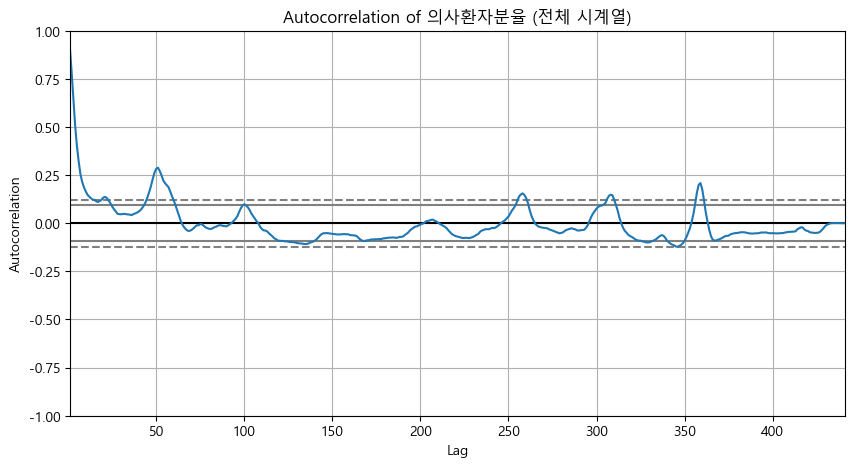

In [ ]:
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot

# 자기상관 그래프를 그려볼 전체 데이터 (train + test 합쳐서 봐야 더 명확함)
combined_df = pd.concat([train_df, test_df]).sort_values("date")

# 시각화
plt.figure(figsize=(10, 5))
autocorrelation_plot(combined_df["65세 이상"])
plt.title("Autocorrelation of 의사환자분율 (전체 시계열)")
plt.grid(True)
plt.show()

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
import pandas as pd

# 의사환자분율이 들어있는 시계열 데이터 (결측 제거 필수)
series = full_df["65세 이상"].dropna()

# 최대 20주까지 lag 확인
nlags = 100

# ACF, PACF 계산
acf_values = acf(series, nlags=nlags)
pacf_values = pacf(series, nlags=nlags)

# 결과를 데이터프레임으로 보기 좋게
acf_df = pd.DataFrame({
    "Lag": list(range(len(acf_values))),
    "ACF": acf_values,
    "PACF": pacf_values
})

acf_df[50:100]

Lag       ACF      PACF
50   50  0.361797  0.076647
51   51  0.391552  0.023274
52   52  0.398390 -0.127292
53   53  0.386516  0.008944
54   54  0.354509 -0.033341
55   55  0.327688  0.167355
56   56  0.303970 -0.043437
57   57  0.280307 -0.042461
58   58  0.247132 -0.131583
59   59  0.215677  0.071570
60   60  0.185968 -0.000312
61   61  0.159702 -0.038716
62   62  0.135169 -0.029800
63   63  0.113750 -0.014458
64   64  0.094233 -0.030411
65   65  0.081829 -0.013356
66   66  0.067477 -0.074638
67   67  0.051886 -0.009162
68   68  0.038134  0.008156
69   69  0.028472 -0.023481
70   70  0.019633 -0.089599
71   71  0.015628 -0.006733
72   72  0.013235  0.026405
73   73  0.013705  0.029900
74   74  0.008235 -0.109782
75   75  0.006019  0.041075
76   76  0.000272 -0.042131
77   77 -0.008208 -0.044601
78   78 -0.017013  0.000196
79   79 -0.023407  0.033725
80   80 -0.028349 -0.015146
81   81 -0.030991 -0.031304
82   82 -0.027932  0.040695
83   83 -0.024358 -0.033692
84   84 -0.021809 -0.015679
85   85 -0.016938  0.051340
86   86 -0.017128 -0.060677
87   87 -0.020775 -0.025830
88   88 -0.022154  0.015391
89   89 -0.025739 -0.028239
90   90 -0.030621 -0.030137
91   91 -0.031254  0.027080
92   92 -0.033670 -0.027630
93   93 -0.034373 -0.034062
94   94 -0.031627 -0.013326
95   95 -0.025520 -0.005906
96   96 -0.017791 -0.009985
97   97 -0.005637 -0.002581
98   98  0.006750  0.004494
99   99  0.021080 -0.009869

In [ ]:
# ✅ best 조합 가져오기
best_row = results_df.iloc[0]
best_lags = eval(best_row["Lags"])
best_rw = best_row["RollingWindow"]

# ✅ 동일한 feature 조합으로 데이터 재생성
df_lagged = create_time_series_features_date_based(full_df, '65세 이상', best_lags)
df_ready = add_rolling_features_date_based(df_lagged, '65세 이상', [best_rw])

lag_cols = [f"lag_{l}" for l in best_lags]
roll_cols = [f"roll_mean_{best_rw}", f"roll_std_{best_rw}"]
time_cols = ["month", "week", "year"]
FEATURES = lag_cols + roll_cols + time_cols + ['코로나']
# ✅ 결측치 제거 및 정렬

df_ready = df_ready.dropna(subset=FEATURES + ['65세 이상'])
df_ready = df_ready.sort_values("date").reset_index(drop=True)

# ✅ 예측 구간 설정
initial_train_end = pd.to_datetime("2024-11-03")
predict_period = pd.Timedelta(weeks=2)
max_date = df_ready["date"].max()
train_end = initial_train_end

# ✅ 비교용 결과 저장 리스트
comparison_rows = []

while train_end + pd.Timedelta(days=1) <= max_date:
    train_df = df_ready[df_ready["date"] <= train_end]
    test_start = train_end + pd.Timedelta(days=1)
    test_end = test_start + predict_period - pd.Timedelta(days=1)

    if test_start > max_date:
        break

    test_df = df_ready[(df_ready["date"] >= test_start) & (df_ready["date"] <= test_end)]
    if test_df.empty:
        train_end = test_end
        continue

    X_train = train_df[FEATURES]
    y_train = train_df["65세 이상"]
    X_test = test_df[FEATURES]
    y_test = test_df["65세 이상"]

    preds_by_model = {}
    for name, model in models.items():
        cloned_model = clone(model)
        cloned_model.fit(X_train, y_train)
        preds = cloned_model.predict(X_test)
        preds_by_model[name] = preds

    # ✅ 각 날짜에 대해 예측값 저장
    for i in range(len(test_df)):
        row = {
            "date": test_df.iloc[i]["date"],
            "실제값": y_test.iloc[i]
            # 코로나도 같이 보고싶다면 "코로나": test_df.iloc[i]["코로나"]
        }
        for name in models.keys():
            row[name] = preds_by_model[name][i]
        comparison_rows.append(row)

    train_end = test_end

# ✅ DataFrame으로 변환
comparison_df = pd.DataFrame(comparison_rows).sort_values("date").reset_index(drop=True)

# ✅ 확인
print(comparison_df.head())

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 519
[LightGBM] [Info] Number of data points in the train set: 521, number of used features: 10
[LightGBM] [Info] Start training from score 2.699040
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [ ]:
comparison_df

date   실제값  RandomForest  GradientBoosting    XGBoost   LightGBM
0  2024-11-04   1.9         1.879          1.768800   1.942358   1.824392
1  2024-11-11   2.0         1.936          1.804479   2.024067   2.059337
2  2024-11-18   2.0         2.023          1.994567   2.132230   2.125341
3  2024-11-25   2.0         2.034          1.994567   2.204784   2.048309
4  2024-12-02   2.3         2.111          2.008090   2.118246   2.060527
5  2024-12-09   3.5         2.896          2.844099   3.191149   2.861135
6  2024-12-16   6.3         4.970          5.122755   4.840873   5.886512
7  2024-12-23  20.3        15.855         16.986056  15.996319  13.667035
8  2024-12-30  27.7        24.135         28.133988  27.430313  21.030412
9  2025-01-06  35.1        26.785         29.813057  30.229746  21.290933
10 2025-01-13  35.2        21.879         23.228963  19.937555  21.118773
11 2025-01-20  21.6        22.281         17.059863  19.145277  15.623653
12 2025-01-27  14.8        20.809         18.249526  19.267124  17.807768
13 2025-02-03  13.5        13.431         13.069173  16.346869  17.807768
14 2025-02-10   5.3        13.105         12.392376  16.805822  12.600046
15 2025-02-17   3.9         7.182          8.267176   5.719341   7.311263
16 2025-02-24   3.0         3.396          4.254265   3.048714   2.775050
17 2025-03-03   2.7         2.957          3.041214   2.716389   1.840273
18 2025-03-10   3.4         2.659          2.895484   2.768824   3.071764
19 2025-03-17   3.4         2.940          2.895484   2.738384   3.058625
20 2025-03-24   3.2         3.389          3.192660   3.412332   3.590939
21 2025-03-31   3.9         3.724          3.672309   3.681303   3.986270

In [ ]:
comparison_df.to_excel('ML for ensemble_old.xlsx', index=False)

## Stacking

In [1]:
import pandas as pd
comparison_df = pd.read_excel('for_ensemble_final.xlsx')

In [2]:
comparison_df.head()

date  실제값  predicted_RandomForest  predicted_GradientBoosting  \
0 2024-11-04  4.0                   3.890                    4.076488   
1 2024-11-11  4.6                   4.404                    4.527490   
2 2024-11-18  4.8                   4.868                    4.990954   
3 2024-11-25  5.7                   5.566                    5.413061   
4 2024-12-02  7.3                   7.137                    6.650740   

   predicted_XGBoost  predicted_LightGBM  predicted_lstm  predicted_cnn_lstm  \
0           3.842892            3.895995        4.679256            5.209977   
1           4.413386            4.564455        3.698463            3.993866   
2           4.910367            4.834959        4.614736            5.046311   
3           5.566297            5.622029        4.958888            6.021397   
4           7.437788            6.136571        6.323768            7.430482   

   predicted_transformer  predicted_SARIMA  predicted_Prophet  predicted_SIR  
0              11.816878          3.236834          17.367111           3.40  
1              14.238399         10.106076          19.565896           3.83  
2               3.616562         17.796305          19.104300           3.97  
3              15.275145         22.630688          19.617129           4.43  
4              14.769758         32.201897          31.560433           4.93

In [3]:
comparison_df.columns

Index(['date', '실제값', 'predicted_RandomForest', 'predicted_GradientBoosting',
       'predicted_XGBoost', 'predicted_LightGBM', 'predicted_lstm',
       'predicted_cnn_lstm', 'predicted_transformer', 'predicted_SARIMA',
       'predicted_Prophet', 'predicted_SIR'],
      dtype='object')

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import clone

# ✅ 사용할 meta model들
meta_models = {
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "SVR": SVR(),
    "XGBoost": XGBRegressor(n_estimators=50, random_state=42)
}

# ✅ 사용할 base model 컬럼
model_cols = ['predicted_RandomForest', 'predicted_GradientBoosting',
       'predicted_XGBoost', 'predicted_LightGBM', 'predicted_lstm',
       'predicted_cnn_lstm', 'predicted_transformer', 'predicted_SARIMA',
       'predicted_Prophet','predicted_SIR']

# ✅ meta model별 결과 저장 딕셔너리
stacking_results = {}

# ✅ 각 meta model별 반복
for meta_name, meta_model in meta_models.items():
    # 복사본 생성
    df = comparison_df.copy()
    df["Stacking_" + meta_name] = np.nan

    # 1. 초반 2개는 성능 기반 가중치로 고정
    mae_scores = {
        model: mean_absolute_error(df["실제값"], df[model])
        for model in model_cols
    }
    inv_mae = {model: 1 / mae for model, mae in mae_scores.items()}
    total_weight = sum(inv_mae.values())
    weights = {model: w / total_weight for model, w in inv_mae.items()}

    for i in range(2):
        row = df.iloc[i]
        weighted_pred = sum(row[model] * weights[model] for model in model_cols)
        df.at[i, "Stacking_" + meta_name] = weighted_pred

    # 2. 이후부터 meta model 점진 학습 & 예측
    for i in range(2, len(df)):
        train_meta = df.iloc[:i].dropna(subset=["Stacking_" + meta_name])
        test_row = df.iloc[i:i+1]

        X_train = train_meta[model_cols]
        y_train = train_meta["실제값"]
        X_test = test_row[model_cols]

        model = clone(meta_model)
        model.fit(X_train, y_train)
        pred = model.predict(X_test)[0]
        df.at[i, "Stacking_" + meta_name] = pred

    stacking_results[meta_name] = df["Stacking_" + meta_name]

# ✅ 최종 결과 정리
for meta_name in stacking_results:
    comparison_df["Stacking_" + meta_name] = stacking_results[meta_name]

# ✅ 성능 비교표 생성
performance = []
for meta_name in meta_models:
    y_true = comparison_df["실제값"]
    y_pred = comparison_df["Stacking_" + meta_name]
    performance.append({
        "MetaModel": meta_name,
        "MAE": round(mean_absolute_error(y_true, y_pred), 3),
        "RMSE": round(np.sqrt(mean_squared_error(y_true, y_pred)), 3),
        "R²": round(r2_score(y_true, y_pred), 3)
    })

performance_df = pd.DataFrame(performance).sort_values(by="MAE")
performance_df

c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.338e-01, tolerance: 4.136e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.652e+00, tolerance: 1.006e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.706e+00, toler

MetaModel     MAE    RMSE     R²
0       Ridge   4.276   6.563  0.929
2  ElasticNet   4.381   6.425  0.932
1       Lasso   4.941   7.537  0.906
4     XGBoost   6.278  12.165  0.755
3         SVR  13.977  27.498 -0.254

In [5]:
comparison_df

date   실제값  predicted_RandomForest  predicted_GradientBoosting  \
0  2024-11-04   4.0                   3.890                    4.076488   
1  2024-11-11   4.6                   4.404                    4.527490   
2  2024-11-18   4.8                   4.868                    4.990954   
3  2024-11-25   5.7                   5.566                    5.413061   
4  2024-12-02   7.3                   7.137                    6.650740   
5  2024-12-09  13.6                  12.999                   13.943247   
6  2024-12-16  31.3                  25.641                   26.904950   
7  2024-12-23  73.9                  56.345                   60.759954   
8  2025-01-06  99.8                  64.001                   66.196781   
9  2025-01-13  86.1                  71.061                   77.583200   
10 2025-01-20  57.7                  68.575                   77.380424   
11 2025-01-27  36.5                  55.584                   38.582944   
12 2025-02-03  30.4                  34.494                   33.706300   
13 2025-02-10  13.9                  19.601                   18.876992   
14 2025-02-17  11.6                  14.297                   14.993625   
15 2025-02-24   9.5                   9.277                    8.732641   
16 2025-03-03   9.1                   8.468                    8.387938   
17 2025-03-10   8.0                   9.122                    9.645946   
18 2025-03-17  10.8                   9.262                   10.222657   
19 2025-03-24  13.2                  12.500                   11.438445   
20 2025-03-31  16.3                  16.877                   15.087316   
21 2025-04-07  16.9                  17.467                   19.271029   
22 2025-04-14  21.6                  18.461                   20.299782   
23 2025-04-21  20.8                  22.835                   24.174019   
24 2025-04-28  16.1                  19.892                   16.671803   
25 2025-05-05  13.1                  15.157                   14.612439   
26 2025-05-12  11.6                  13.339                   13.089375   
27 2025-05-19  10.1                   9.028                   10.073352   
28 2025-05-26   7.3                   8.007                    8.540746   

    predicted_XGBoost  predicted_LightGBM  predicted_lstm  predicted_cnn_lstm  \
0            3.842892            3.895995        4.679256            5.209977   
1            4.413386            4.564455        3.698463            3.993866   
2            4.910367            4.834959        4.614736            5.046311   
3            5.566297            5.622029        4.958888            6.021397   
4            7.437788            6.136571        6.323768            7.430482   
5           13.275219           11.330908       10.067959            9.348881   
6           29.944063           28.304265       19.347874           20.738627   
7           59.960903           57.095955       49.679939           54.340646   
8           48.402981           59.665455      106.765142           92.556171   
9           64.904144           53.176903       82.308242           92.556171   
10          48.606579           57.940271       57.499139           70.672436   
11          45.012848           61.985569       39.383002           61.804314   
12          28.192474           38.323955       21.282270           46.771590   
13          16.549585           21.231557       26.231877           28.631764   
14          14.001782           12.096298        7.134059           21.384212   
15           8.639894           10.354175        6.038529            7.106356   
16           7.469651            8.875162        6.307217            5.845918   
17           9.690524            8.714770        8.535304            8.121863   
18           9.811362            9.787926        7.860843            8.523165   
19          12.851443           13.680254       13.812969            6.929350   
20          16.794092           18.723318       18.352865

In [6]:
comparison_df.to_excel('stacking_ensemble.xlsx')

## 그래프 그리기

In [9]:
import pandas as pd

df = pd.read_excel('all_final_ensemble_results.xlsx')

In [10]:
df.columns

Index(['date', '실제값', 'predicted_RandomForest', 'predicted_GradientBoosting',
       'predicted_XGBoost', 'predicted_LightGBM', 'predicted_lstm',
       'predicted_cnn_lstm', 'predicted_transformer', 'predicted_SARIMA',
       'predicted_Prophet', 'predicted_SIR', 'R2_Weighted_Ensemble',
       'RMSE_Weighted_Ensemble', 'Top5_SimpleAvg_Ensemble',
       'Top5_R2Weighted_Ensemble', 'Optimized_Weighted_Ensemble',
       'Segmented_Ensemble', 'Segmented_R2Weighted_Ensemble',
       'Dynamic_Ensemble', 'Stacking_Ridge', 'Stacking_Lasso',
       'Stacking_ElasticNet', 'Stacking_XGBoost', 'Unnamed: 24', 'Model', 'R2',
       'RMSE', 'MAE'],
      dtype='object')

In [11]:
df = df[['date', '실제값','predicted_RandomForest',
       'predicted_GradientBoosting', 'predicted_XGBoost', 'predicted_LightGBM',
       'Stacking_Ridge',
       'Stacking_Lasso', 'Stacking_ElasticNet', 'Stacking_XGBoost']]

In [12]:
df

date   실제값  predicted_RandomForest  predicted_GradientBoosting  \
0  2024-11-04   4.0                   3.890                    4.076488   
1  2024-11-11   4.6                   4.404                    4.527490   
2  2024-11-18   4.8                   4.868                    4.990954   
3  2024-11-25   5.7                   5.566                    5.413061   
4  2024-12-02   7.3                   7.137                    6.650740   
5  2024-12-09  13.6                  12.999                   13.943247   
6  2024-12-16  31.3                  25.641                   26.904950   
7  2024-12-23  73.9                  56.345                   60.759954   
8  2025-01-06  99.8                  64.001                   66.196781   
9  2025-01-13  86.1                  71.061                   77.583200   
10 2025-01-20  57.7                  68.575                   77.380424   
11 2025-01-27  36.5                  55.584                   38.582944   
12 2025-02-03  30.4                  34.494                   33.706300   
13 2025-02-10  13.9                  19.601                   18.876992   
14 2025-02-17  11.6                  14.297                   14.993625   
15 2025-02-24   9.5                   9.277                    8.732641   
16 2025-03-03   9.1                   8.468                    8.387938   
17 2025-03-10   8.0                   9.122                    9.645946   
18 2025-03-17  10.8                   9.262                   10.222657   
19 2025-03-24  13.2                  12.500                   11.438445   
20 2025-03-31  16.3                  16.877                   15.087316   
21 2025-04-07  16.9                  17.467                   19.271029   
22 2025-04-14  21.6                  18.461                   20.299782   
23 2025-04-21  20.8                  22.835                   24.174019   
24 2025-04-28  16.1                  19.892                   16.671803   
25 2025-05-05  13.1                  15.157                   14.612439   
26 2025-05-12  11.6                  13.339                   13.089375   
27 2025-05-19  10.1                   9.028                   10.073352   
28 2025-05-26   7.3                   8.007                    8.540746   

    predicted_XGBoost  predicted_LightGBM  Stacking_Ridge  Stacking_Lasso  \
0            3.842892            3.895995        5.328306        5.328306   
1            4.413386            4.564455        5.980145        5.980145   
2            4.910367            4.834959        4.824785        4.328656   
3            5.566297            5.622029        5.406106        4.786394   
4            7.437788            6.136571        6.461353        5.898956   
5           13.275219           11.330908        9.261780        7.672244   
6           29.944063           28.304265       28.721312       21.887204   
7           59.960903           57.095955       64.586514       49.125687   
8           48.402981           59.665455       98.395181       96.004003   
9           64.904144           53.176903      109.390390      100.422629   
10          48.606579           57.940271       69.893688       76.284863   
11          45.012848           61.985569       35.014196       41.231332   
12          28.192474           38.323955       17.499768       18.034236   
13          16.549585           21.231557       20.012409       17.962635   
14          14.001782           12.096298       20.605024       17.256464   
15           8.639894           10.354175        3.919294        4.886679   
16           7.469651            8.875162        5.943915        5.277118   
17           9.690524            8.714770       10.811365        9.731293   
18           9.811362            9.787926       11.503732        9.208538   
19          12.851443           13.680254        9.986982        9.554392   
20          16.794092           18.723318       18.581397       17.761245   
21          19.350641           21.360830       22.804936       

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# 날짜 컬럼을 datetime 형식으로 변환
df['date'] = pd.to_datetime(df['date'])

# 모델 목록
model_columns = [
    'predicted_RandomForest',
    'predicted_GradientBoosting',
    'predicted_XGBoost',
    'predicted_LightGBM',
    'Stacking_Ridge',
    'Stacking_Lasso',
    'Stacking_ElasticNet',
    'Stacking_XGBoost'
]

# 실제값
true_values = df['실제값']
dates = df['date']

# 모델별 그래프 생성 및 저장
for model in model_columns:
    plt.figure(figsize=(10, 4))
    plt.plot(dates, true_values, label='실제값', color='black', linewidth=2)
    plt.plot(dates, df[model], label=model, linestyle='--')
    plt.title(f'{model} 예측 결과')
    plt.xlabel('날짜')
    plt.ylabel('의사환자분율')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    # 파일명: 모델 이름에서 'predicted_' 접두어 제거하고 저장
    filename = f'{model.replace("predicted_", "")}_prediction.png'
    plt.savefig(filename, dpi=300)
    plt.close()


In [16]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


# 실제값
y_true = df['실제값']

# 모델 컬럼 리스트
model_columns = [
    'predicted_RandomForest',
    'predicted_GradientBoosting',
    'predicted_XGBoost',
    'predicted_LightGBM',
    'Stacking_Ridge',
    'Stacking_Lasso',
    'Stacking_ElasticNet',
    'Stacking_XGBoost'
]

# 결과 저장용 리스트
results = []

# 각 모델별로 성능 계산
for model in model_columns:
    y_pred = df[model]
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)  # squared=False → RMSE
    r2 = r2_score(y_true, y_pred)
    
    results.append({
        'Model': model,
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'R2': round(r2, 3)
    })

# 결과를 데이터프레임으로 정리
score_df = pd.DataFrame(results)
score_df.sort_values(by='RMSE', inplace=True)  # RMSE 기준 오름차순 정렬

# 보기 좋게 출력
score_df

c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

Model   MAE   RMSE     R2
6         Stacking_ElasticNet  4.38   6.43  0.932
4              Stacking_Ridge  4.28   6.56  0.929
5              Stacking_Lasso  4.94   7.54  0.906
1  predicted_GradientBoosting  3.91   8.02  0.893
0      predicted_RandomForest  4.75   9.15  0.861
2           predicted_XGBoost  4.67  11.02  0.798
3          predicted_LightGBM  5.73  11.56  0.778
7            Stacking_XGBoost  6.28  12.16  0.755